# DNN vs. SVN

Let's see if we can fit data with low-dimensional features with a DNN as good as a SVM. We will examine two cases:
 - Classification of a spherically distributed data with SVM (with a number of kernels).
 - Classification of the same data with a DNN.
 - Classification of a random dataset of the same size as the previous one with both the DNN and the SVM.

In [2]:
import tensorflow as tf

from sklearn import svm
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

import copy

-----
## Ellipsoidal Data Generator

In [3]:
## Ellipsoidal Distribution:
def Ellipsoid( r,
               theta, 
               phi, 
               mat=None, 
               rx=1., 
               ry=1.  ):
    """
    Retunrs the (x,y,z) coordiantes corresponding to the (r,theta,phi)
    tuple for a rotated ellipsoid along with radii (rx*r,ry*r,r.)
    
    Args:
        r (np.array):       Array of radii.
        theta (np.array):   Theta angle array.
        phi (np.array):     Phi angle array.
        mat (3x3 np.array): Matrix to transform coordinates with (e.g., rotation).
        rx (float):         X radius.
        ry (float):         Y radius.
        
    Retursn:
        np.array of shape (n,3)
    """
    assert( theta.shape==phi.shape )
    if( isinstance(r,float) or isinstance(r,int) ):
        temp_x = r*rx*np.sin(np.ravel(theta))*np.cos(np.ravel(phi))
        temp_y = r*ry*np.sin(np.ravel(theta))*np.sin(np.ravel(phi))
        temp_z = r*np.cos(np.ravel(theta))
        temp = np.c_[temp_x,temp_y,temp_z]
        del temp_x, temp_y, temp_z 
    elif( isinstance(r,np.ndarray) ):
        assert( r.shape==theta.shape )
        temp_x = r*rx*np.sin(np.ravel(theta))*np.cos(np.ravel(phi))
        temp_y = r*ry*np.sin(np.ravel(theta))*np.sin(np.ravel(phi))
        temp_z = r*np.cos(np.ravel(theta))
        temp = np.c_[temp_x,temp_y,temp_z]
        del temp_x, temp_y, temp_z 
    else:
        raise Exception("\"r\" has to be a float or np.ndarray!")
    #
    if( mat is not None ):
        if( mat.shape != (3,3) ):
            raise Exception("Rotation matrix has to be 3x3!")
        #
        return np.matmul(temp,np.transpose(mat))
    else:
        return temp

    
## TensorFlow Keras Model Generator:
def DNNConstructor( inputSize, hiddenLayersMap={1:16,2:32,3:64,4:32,5:32,6:16,7:8}, activation=tf.nn.relu ):
    """
    Constructs and retursn a tf.keras model
    
    Args:
        inputSize (int):        Number of digits.
        hiddenLayersMap (dict): If provided, the *hidden* layers are constructed as oputlined.
    
    Returns:
        tf.keras.model
    """
    model_ = tf.keras.models.Sequential()
    for l in sorted(hiddenLayersMap,reverse=False):
        if( l==1 ):
            model_.add( tf.keras.layers.Dense(  hiddenLayersMap[l], 
                                                input_dim=inputSize, 
                                                activation=copy.deepcopy(activation),
                                                use_bias=True,
                                                kernel_initializer='glorot_uniform',
                                                bias_initializer='zeros',
                                                kernel_regularizer=None,
                                                bias_regularizer=None,
                                                activity_regularizer=None,
                                                kernel_constraint=None,
                                                bias_constraint=None,
                                                name="Dense_"+str(l)     ) )
        else:
            model_.add( tf.keras.layers.Dense(  hiddenLayersMap[l],  
                                                activation=copy.deepcopy(activation),
                                                use_bias=True,
                                                kernel_initializer='glorot_uniform',
                                                bias_initializer='zeros',
                                                kernel_regularizer=None,
                                                bias_regularizer=None,
                                                activity_regularizer=None,
                                                kernel_constraint=None,
                                                bias_constraint=None,
                                                name="Dense_"+str(l)     ) )
    model_.add( tf.keras.layers.Dense(2, activation=tf.nn.softmax,name="Softmax") )
    #
    return model_

-----
## Case I: Two Concentric Ellipsoids 

We geenrate two ellipsoidally disributed sets, which both are rotated by the same rotation matrix. SVM classifier should be able to classify this with very high accuracy.

Class A:  (10110, 3)
Class B:  (10100, 3)


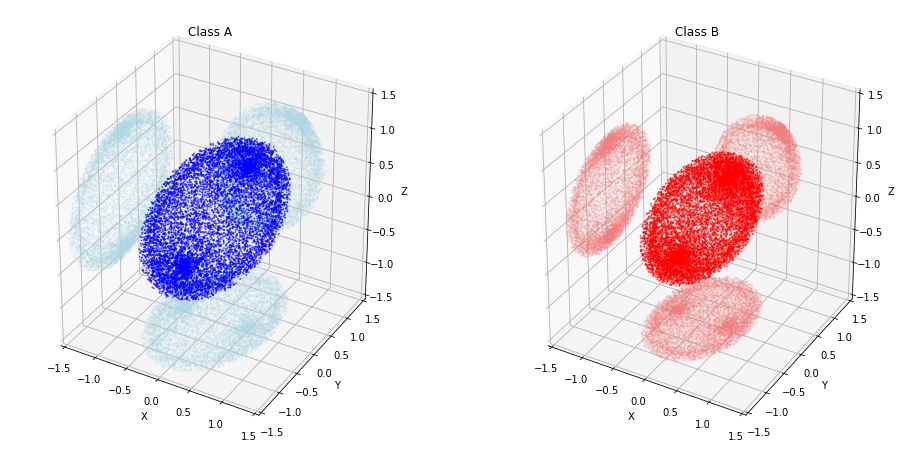

Full  Set Size:  20210
Train Set Size:  16168
Test  Set Size:  4042


In [5]:
## Define Two Classes: A & B:
n = 10110
r = 0.9+0.2*np.random.rand(n)
t = np.random.rand(n)*np.pi
p = np.random.rand(n)*2.0*np.pi
rot_ang = np.pi/6.0
rot_mat = np.array([ [np.cos(rot_ang),  0., np.sin(rot_ang)],
                     [      0.,         1.,       0.       ],
                     [-np.sin(rot_ang), 0., np.cos(rot_ang)] ])
classA = Ellipsoid( r=r, theta=t, phi=p, mat=rot_mat, rx=.75, ry=1.25)
print( "Class A: ", classA.shape )
#
n = 10100
r = 0.7+0.2*np.random.rand(n)
t = np.random.rand(n)*np.pi
p = np.random.rand(n)*2.0*np.pi
rot_ang = np.pi/6.0
rot_mat = np.array([ [np.cos(rot_ang),  0., np.sin(rot_ang)],
                     [      0.,         1.,       0.       ],
                     [-np.sin(rot_ang), 0., np.cos(rot_ang)] ])
classB = Ellipsoid( r=r, theta=t, phi=p, mat=rot_mat, rx=.75, ry=1.25)
print( "Class B: ", classB.shape )
#
## Visualize the results
fig = plt.figure(figsize=(16, 8))
#
ax = fig.add_subplot(121, projection='3d')
ax.set_title( "Class A" )
ax.scatter( classA[:,0], classA[:,1], classA[:,2], 
            s=1., c='b', marker='o', alpha=.5, label='Class A' )
ax.scatter( classA[:,0], classA[:,2], marker='o', c='lightblue', alpha=.15, s=1., zdir='y', zs=+1.5)  # XZ
ax.scatter( classA[:,1], classA[:,2], marker='o', c='lightblue', alpha=.15, s=1., zdir='x', zs=-1.5)  # YZ
ax.scatter( classA[:,0], classA[:,1], marker='o', c='lightblue', alpha=.15, s=1., zdir='z', zs=-1.5)  # XY
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-1.5,1.5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#
ax = fig.add_subplot(122, projection='3d')
ax.set_title( "Class B" )
ax.scatter( classB[:,0], classB[:,1], classB[:,2], 
            s=1., c='r', marker='o', alpha=.5, label='Class B' )
ax.scatter( classB[:,0], classB[:,2], marker='o', c='lightcoral', alpha=.15, s=1., zdir='y', zs=+1.5)  # XZ
ax.scatter( classB[:,1], classB[:,2], marker='o', c='lightcoral', alpha=.15, s=1., zdir='x', zs=-1.5)  # YZ
ax.scatter( classB[:,0], classB[:,1], marker='o', c='lightcoral', alpha=.15, s=1., zdir='z', zs=-1.5)  # XY
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-1.5,1.5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#
plt.show()
#
#================================================
## Split data into train and test sets: 
X = np.concatenate((classA,classB),axis=0)
Y = np.concatenate((np.zeros(max(classA.shape),dtype=np.uint8),
                    np.ones(max(classB.shape),dtype=np.uint8)),axis=0)
indcies_array = np.random.randint( low=0, high=(max(X.shape)-1), size=max(X.shape) )
x_train = X[ indcies_array[int(0.2*max(X.shape)):] ]
y_train = Y[ indcies_array[int(0.2*max(X.shape)):] ]
x_test = X[ indcies_array[0:int(0.2*max(X.shape))] ]
y_test = Y[ indcies_array[0:int(0.2*max(X.shape))] ]
print( "Full  Set Size: ", max(Y.shape) )
print( "Train Set Size: ", max(y_train.shape) )
print( "Test  Set Size: ", max(y_test.shape) )

### Classification with SVM for Case I:

              precision    recall  f1-score   support

     class A       0.99      1.00      0.99      2026
     class B       1.00      0.99      0.99      2016

    accuracy                           0.99      4042
   macro avg       0.99      0.99      0.99      4042
weighted avg       0.99      0.99      0.99      4042



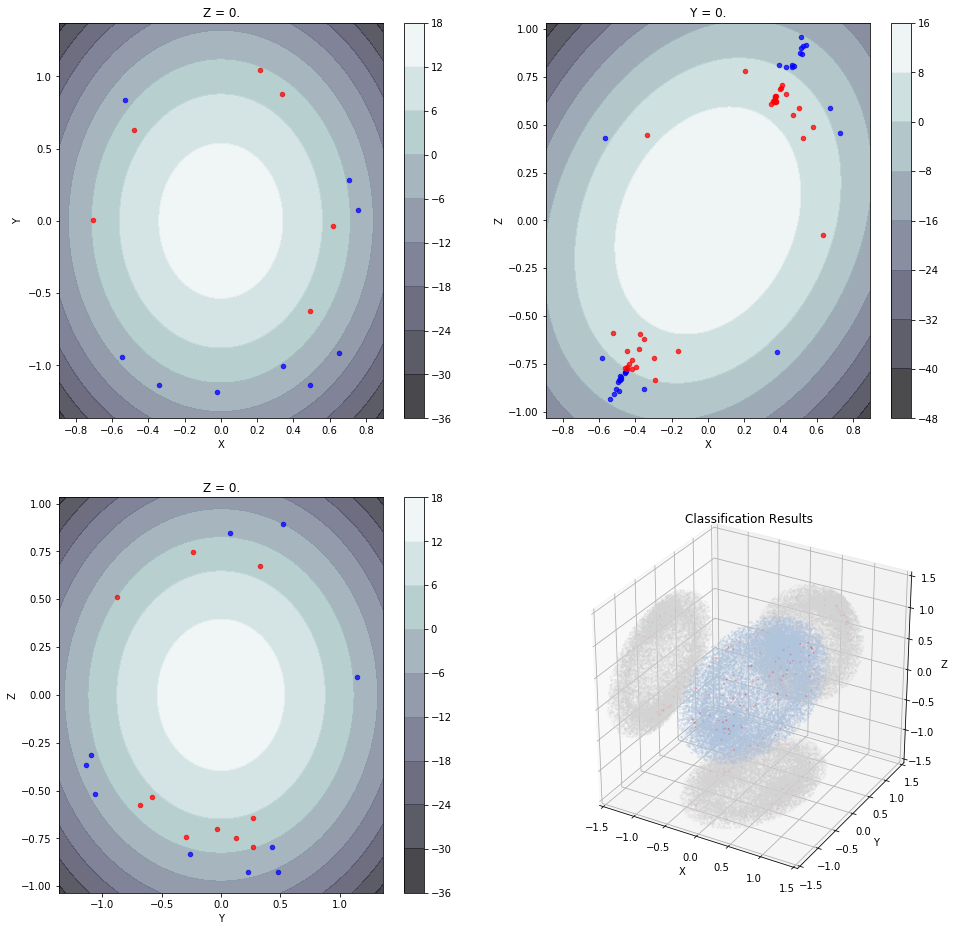

In [8]:
clf = svm.SVC( kernel='poly',
               degree=2,
               gamma='scale',
               cache_size=2000.,
               class_weight='balanced' )
clf.fit( x_train, y_train )
class_names = ['class A', 'class B']
print( classification_report( y_test, 
                              clf.predict(x_test), 
                              target_names=class_names )  )
#
## Visualize the fit:
minVals = np.minimum( classA.min(axis=0), classB.min(axis=0) )
maxVals = np.maximum( classA.max(axis=0), classB.max(axis=0) )
x_array = np.linspace( minVals[0], maxVals[0], 100)
y_array = np.linspace( minVals[1], maxVals[1], 100)
z_array = np.linspace( minVals[2], maxVals[2], 100)
##
fig = plt.figure(figsize=(16,16))
#
ax = fig.add_subplot(221)
xx, yy = np.meshgrid( x_array, y_array )
cr = clf.decision_function( np.c_[xx.ravel(), 
                                  yy.ravel(), 
                                  np.zeros_like(xx).ravel()] )
cr = cr.reshape(xx.shape)
cb = ax.contourf(xx, yy, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,2]>-0.001,classA[:,2]<0.001), 0],
            classA[ np.logical_and(classA[:,2]>-0.001,classA[:,2]<0.001), 1], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,2]>-0.001,classB[:,2]<0.001), 0],
            classB[ np.logical_and(classB[:,2]>-0.001,classB[:,2]<0.001), 1], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Z = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(222)
xx, zz = np.meshgrid( x_array, z_array )
cr = clf.decision_function( np.c_[xx.ravel(), 
                                  np.zeros_like(xx).ravel(), 
                                  zz.ravel()] )
cr = cr.reshape(xx.shape)
cb = ax.contourf(xx, zz, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,1]>-0.001,classA[:,1]<0.001), 0],
            classA[ np.logical_and(classA[:,1]>-0.001,classA[:,1]<0.001), 2], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,1]>-0.001,classB[:,1]<0.001), 0],
            classB[ np.logical_and(classB[:,1]>-0.001,classB[:,1]<0.001), 2], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Y = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(223)
yy, zz = np.meshgrid( y_array, z_array )
cr = clf.decision_function( np.c_[np.zeros_like(yy).ravel(),
                                  yy.ravel(), 
                                  zz.ravel()] )
cr = cr.reshape(yy.shape)
cb = ax.contourf(yy, zz, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,0]>-0.001,classA[:,0]<0.001), 1],
            classA[ np.logical_and(classA[:,0]>-0.001,classA[:,0]<0.001), 2], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,0]>-0.001,classB[:,0]<0.001), 1],
            classB[ np.logical_and(classB[:,0]>-0.001,classB[:,0]<0.001), 2], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Z = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(224, projection='3d')
ax.set_title( "Classification Results" )
colors = np.where( Y==clf.predict(X), 'lightsteelblue', 'red' )
temp_features = np.concatenate((classA,classB),axis=0)
ax.scatter( temp_features[:,0], temp_features[:,1], temp_features[:,2], 
            s=1., c=colors, marker='o', alpha=.25 )
colors = np.where( Y==clf.predict(X), 'lightgray', 'lightcoral' )
ax.scatter( temp_features[:,0], temp_features[:,2], marker='o', c=colors, alpha=.15, s=1., zdir='y', zs=+1.5)  # XZ
ax.scatter( temp_features[:,1], temp_features[:,2], marker='o', c=colors, alpha=.15, s=1., zdir='x', zs=-1.5)  # YZ
ax.scatter( temp_features[:,0], temp_features[:,1], marker='o', c=colors, alpha=.15, s=1., zdir='z', zs=-1.5)  # XY
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-1.5,1.5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#
plt.show()

### Classification with DNN for Case I:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 16)                64        
_________________________________________________________________
Dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_7 (Dense)              (None, 16)                2

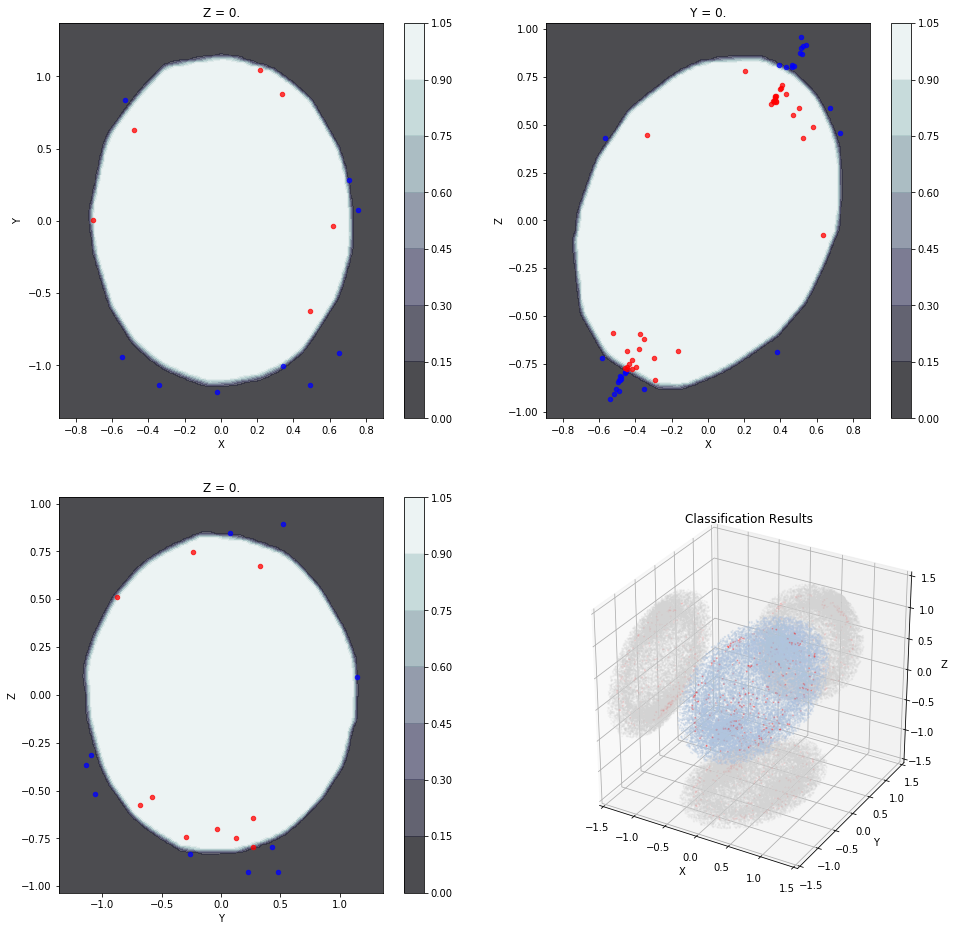

In [11]:
## First, reset the default graph...
tf.reset_default_graph()
#
## Construct Model
hLayersDict = {1:16, 2:16, 3:16, 4:16, 5:16, 6:16, 7:16}
model = DNNConstructor(3, hLayersDict)
print( model.summary() )
#
##=========================================#
##             Training DNN                #
##=========================================#
## Compiling the model:
model.compile( optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy']  )
#
## We add a tensorboard callback:
tbCallBack = tf.keras.callbacks.TensorBoard( log_dir='./DNN_vs_SVM_I', 
                                             histogram_freq=1,
                                             batch_size=32, 
                                             write_graph=True, 
                                             write_images=True,
                                             write_grads=True,
                                             update_freq='epoch')
#
## Early stopping callback to prevent overfitting:
earlystopCallback = tf.keras.callbacks.EarlyStopping( monitor='val_loss',
                                                      min_delta=0.0001,
                                                      patience=10,
                                                      verbose=0,
                                                      mode='auto',
                                                      baseline=None,
                                                      restore_best_weights=True )
#
## Train model
model.fit( x=x_train,
           y=y_train,
           batch_size=32,
           epochs=10000,
           verbose=1,
           callbacks=[earlystopCallback,tbCallBack],
           validation_split=0.2,
           #validation_data=None,
           shuffle=True,
           #class_weight=None,
           sample_weight=None,
           initial_epoch=0,
           steps_per_epoch=None,
           #validation_steps=None,
           #validation_freq=1,
           #max_queue_size=10,
           workers=8,
           use_multiprocessing=True )
#
## Predict based on the Test Set:
y_test_predict = model.predict( x=x_test,
                                workers=8,
                                use_multiprocessing=True )
#
## Evaluate Metrics:
print( classification_report( y_test, 
                              np.argmax(y_test_predict,axis=1), 
                              target_names=class_names )  )

#=============================================================================
## Visualize the result:
#    The idea is to use the probability for the "1"
#    class for the contour plots: P(Class_B)=1
minVals = np.minimum( classA.min(axis=0), classB.min(axis=0) )
maxVals = np.maximum( classA.max(axis=0), classB.max(axis=0) )
x_array = np.linspace( minVals[0], maxVals[0], 100)
y_array = np.linspace( minVals[1], maxVals[1], 100)
z_array = np.linspace( minVals[2], maxVals[2], 100)
##
fig = plt.figure(figsize=(16,16))
#
ax = fig.add_subplot(221)
xx, yy = np.meshgrid( x_array, y_array )
cr = model.predict( x=np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx).ravel()],
                    workers=8,
                    use_multiprocessing=True )[:,1]
cr = cr.reshape(xx.shape)
cb = ax.contourf(xx, yy, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,2]>-0.001,classA[:,2]<0.001), 0],
            classA[ np.logical_and(classA[:,2]>-0.001,classA[:,2]<0.001), 1], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,2]>-0.001,classB[:,2]<0.001), 0],
            classB[ np.logical_and(classB[:,2]>-0.001,classB[:,2]<0.001), 1], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Z = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(222)
xx, zz = np.meshgrid( x_array, z_array )
cr = model.predict( x=np.c_[xx.ravel(), np.zeros_like(xx).ravel(), zz.ravel()],
                    workers=8,
                    use_multiprocessing=True )[:,1]
cr = cr.reshape(xx.shape)
cb = ax.contourf(xx, zz, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,1]>-0.001,classA[:,1]<0.001), 0],
            classA[ np.logical_and(classA[:,1]>-0.001,classA[:,1]<0.001), 2], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,1]>-0.001,classB[:,1]<0.001), 0],
            classB[ np.logical_and(classB[:,1]>-0.001,classB[:,1]<0.001), 2], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Y = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(223)
yy, zz = np.meshgrid( y_array, z_array )
cr = model.predict( x=np.c_[np.zeros_like(yy).ravel(),yy.ravel(), zz.ravel()],
                    workers=8,
                    use_multiprocessing=True )[:,1]
cr = cr.reshape(yy.shape)
cb = ax.contourf(yy, zz, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,0]>-0.001,classA[:,0]<0.001), 1],
            classA[ np.logical_and(classA[:,0]>-0.001,classA[:,0]<0.001), 2], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,0]>-0.001,classB[:,0]<0.001), 1],
            classB[ np.logical_and(classB[:,0]>-0.001,classB[:,0]<0.001), 2], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Z = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(224, projection='3d')
ax.set_title( "Classification Results" )
Y_pred = np.argmax( model.predict(x=X,workers=8,use_multiprocessing=True), axis=1 )
colors = np.where( Y==Y_pred, 'lightsteelblue', 'red' )
temp_features = np.concatenate((classA,classB),axis=0)
ax.scatter( temp_features[:,0], temp_features[:,1], temp_features[:,2], 
            s=1., c=colors, marker='o', alpha=.25 )
colors = np.where( Y==Y_pred, 'lightgray', 'lightcoral' )
ax.scatter( temp_features[:,0], temp_features[:,2], marker='o', c=colors, alpha=.15, s=1., zdir='y', zs=+1.5)  # XZ
ax.scatter( temp_features[:,1], temp_features[:,2], marker='o', c=colors, alpha=.15, s=1., zdir='x', zs=-1.5)  # YZ
ax.scatter( temp_features[:,0], temp_features[:,1], marker='o', c=colors, alpha=.15, s=1., zdir='z', zs=-1.5)  # XY
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-1.5,1.5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#
plt.show()

----
## Case II: Rotated Concentric Ellipsoids

This time, we generate two ellipsoidally-distributed set of points where the eelipsoids are rotated in different directions. This should have an immediate impact on the classification accuracy of the SVM classfier.

Class A:  (10110, 3)
Class B:  (10100, 3)


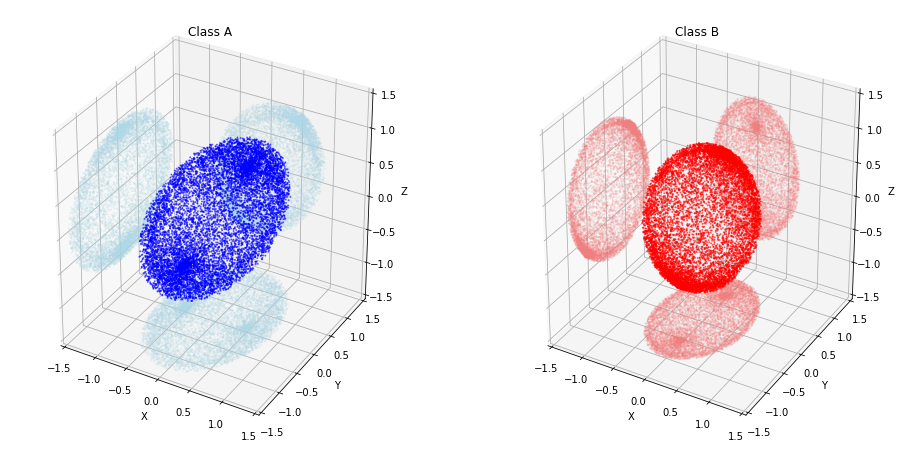

Full  Set Size:  20210
Train Set Size:  16168
Test  Set Size:  4042


In [15]:
## Define Two Classes: A & B:
n = 10110
r = 0.9+0.2*np.random.rand(n)
t = np.random.rand(n)*np.pi
p = np.random.rand(n)*2.0*np.pi
rot_ang = np.pi/6.0
rot_mat = np.array([ [np.cos(rot_ang),  0., np.sin(rot_ang)],
                     [      0.,         1.,       0.       ],
                     [-np.sin(rot_ang), 0., np.cos(rot_ang)] ])
classA = Ellipsoid( r=r, theta=t, phi=p, mat=rot_mat, rx=.75, ry=1.25)
print( "Class A: ", classA.shape )
#
n = 10100
r = 0.85+0.1*np.random.rand(n)
t = np.random.rand(n)*np.pi
p = np.random.rand(n)*2.0*np.pi
rot_ang = np.pi/4.0
rot_mat = np.array([ [      1.,                  0.,         0.          ],
                     [      0.,          np.cos(rot_ang), np.sin(rot_ang)],
                     [      0.,         -np.sin(rot_ang), np.cos(rot_ang)] ])
classB = Ellipsoid( r=r, theta=t, phi=p, mat=rot_mat, rx=.75, ry=1.25)
print( "Class B: ", classB.shape )
#
## Visualize the results
fig = plt.figure(figsize=(16, 8))
#
ax = fig.add_subplot(121, projection='3d')
ax.set_title( "Class A" )
ax.scatter( classA[:,0], classA[:,1], classA[:,2], 
            s=1., c='b', marker='o', alpha=.5, label='Class A' )
ax.scatter( classA[:,0], classA[:,2], marker='o', c='lightblue', alpha=.15, s=1., zdir='y', zs=+1.5)  # XZ
ax.scatter( classA[:,1], classA[:,2], marker='o', c='lightblue', alpha=.15, s=1., zdir='x', zs=-1.5)  # YZ
ax.scatter( classA[:,0], classA[:,1], marker='o', c='lightblue', alpha=.15, s=1., zdir='z', zs=-1.5)  # XY
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-1.5,1.5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#
ax = fig.add_subplot(122, projection='3d')
ax.set_title( "Class B" )
ax.scatter( classB[:,0], classB[:,1], classB[:,2], 
            s=1., c='r', marker='o', alpha=.5, label='Class B' )
ax.scatter( classB[:,0], classB[:,2], marker='o', c='lightcoral', alpha=.15, s=1., zdir='y', zs=+1.5)  # XZ
ax.scatter( classB[:,1], classB[:,2], marker='o', c='lightcoral', alpha=.15, s=1., zdir='x', zs=-1.5)  # YZ
ax.scatter( classB[:,0], classB[:,1], marker='o', c='lightcoral', alpha=.15, s=1., zdir='z', zs=-1.5)  # XY
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-1.5,1.5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#
plt.show()
#
#================================================
## Split data into train and test sets: 
X = np.concatenate((classA,classB),axis=0)
Y = np.concatenate((np.zeros(max(classA.shape),dtype=np.uint8),
                    np.ones(max(classB.shape),dtype=np.uint8)),axis=0)
indcies_array = np.random.randint( low=0, high=(max(X.shape)-1), size=max(X.shape) )
x_train = X[ indcies_array[int(0.2*max(X.shape)):] ]
y_train = Y[ indcies_array[int(0.2*max(X.shape)):] ]
x_test = X[ indcies_array[0:int(0.2*max(X.shape))] ]
y_test = Y[ indcies_array[0:int(0.2*max(X.shape))] ]
print( "Full  Set Size: ", max(Y.shape) )
print( "Train Set Size: ", max(y_train.shape) )
print( "Test  Set Size: ", max(y_test.shape) )

              precision    recall  f1-score   support

     class A       0.95      0.75      0.84      2033
     class B       0.79      0.96      0.87      2009

    accuracy                           0.85      4042
   macro avg       0.87      0.85      0.85      4042
weighted avg       0.87      0.85      0.85      4042



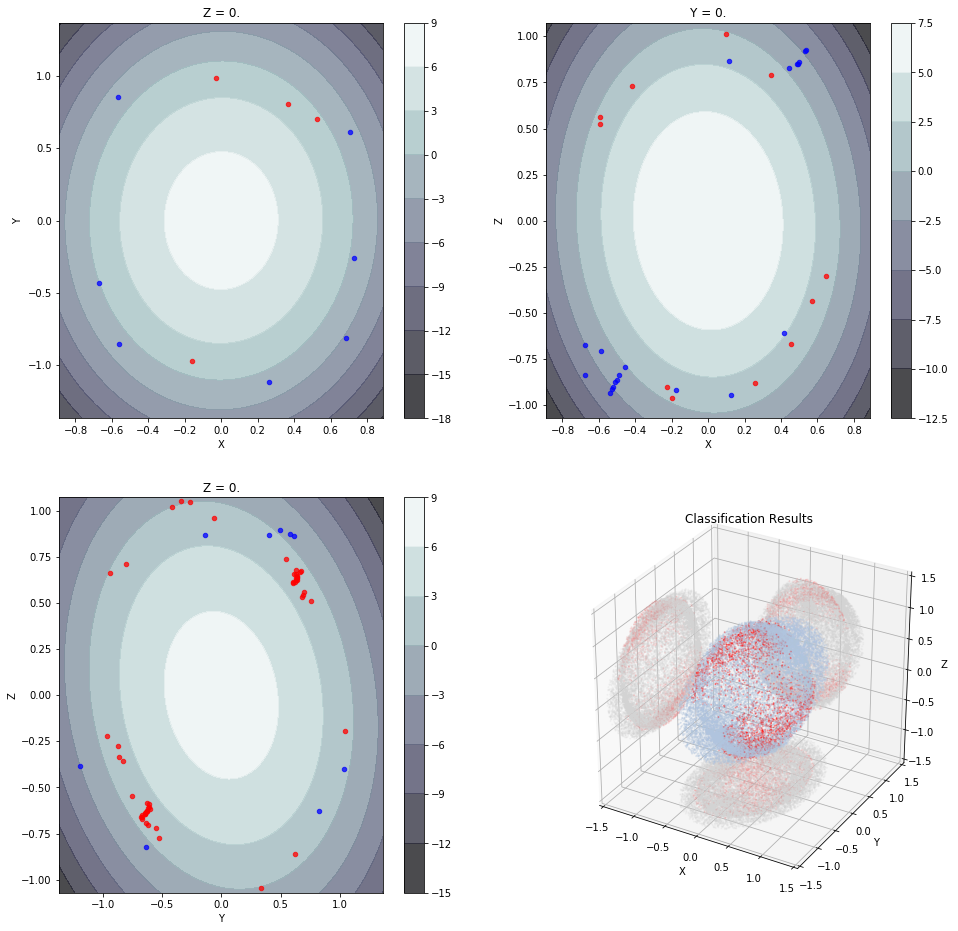

In [16]:
clf = svm.SVC( kernel='poly',
               degree=2,
               gamma='scale',
               cache_size=2000.,
               class_weight='balanced' )
clf.fit( x_train, y_train )
class_names = ['class A', 'class B']
print( classification_report( y_test, 
                              clf.predict(x_test), 
                              target_names=class_names )  )
#
## Visualize the fit:
minVals = np.minimum( classA.min(axis=0), classB.min(axis=0) )
maxVals = np.maximum( classA.max(axis=0), classB.max(axis=0) )
x_array = np.linspace( minVals[0], maxVals[0], 100)
y_array = np.linspace( minVals[1], maxVals[1], 100)
z_array = np.linspace( minVals[2], maxVals[2], 100)
##
fig = plt.figure(figsize=(16,16))
#
ax = fig.add_subplot(221)
xx, yy = np.meshgrid( x_array, y_array )
cr = clf.decision_function( np.c_[xx.ravel(), 
                                  yy.ravel(), 
                                  np.zeros_like(xx).ravel()] )
cr = cr.reshape(xx.shape)
cb = ax.contourf(xx, yy, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,2]>-0.001,classA[:,2]<0.001), 0],
            classA[ np.logical_and(classA[:,2]>-0.001,classA[:,2]<0.001), 1], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,2]>-0.001,classB[:,2]<0.001), 0],
            classB[ np.logical_and(classB[:,2]>-0.001,classB[:,2]<0.001), 1], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Z = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(222)
xx, zz = np.meshgrid( x_array, z_array )
cr = clf.decision_function( np.c_[xx.ravel(), 
                                  np.zeros_like(xx).ravel(), 
                                  zz.ravel()] )
cr = cr.reshape(xx.shape)
cb = ax.contourf(xx, zz, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,1]>-0.001,classA[:,1]<0.001), 0],
            classA[ np.logical_and(classA[:,1]>-0.001,classA[:,1]<0.001), 2], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,1]>-0.001,classB[:,1]<0.001), 0],
            classB[ np.logical_and(classB[:,1]>-0.001,classB[:,1]<0.001), 2], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Y = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(223)
yy, zz = np.meshgrid( y_array, z_array )
cr = clf.decision_function( np.c_[np.zeros_like(yy).ravel(),
                                  yy.ravel(), 
                                  zz.ravel()] )
cr = cr.reshape(yy.shape)
cb = ax.contourf(yy, zz, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,0]>-0.001,classA[:,0]<0.001), 1],
            classA[ np.logical_and(classA[:,0]>-0.001,classA[:,0]<0.001), 2], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,0]>-0.001,classB[:,0]<0.001), 1],
            classB[ np.logical_and(classB[:,0]>-0.001,classB[:,0]<0.001), 2], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Z = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(224, projection='3d')
ax.set_title( "Classification Results" )
colors = np.where( Y==clf.predict(X), 'lightsteelblue', 'red' )
temp_features = np.concatenate((classA,classB),axis=0)
ax.scatter( temp_features[:,0], temp_features[:,1], temp_features[:,2], 
            s=1., c=colors, marker='o', alpha=.25 )
colors = np.where( Y==clf.predict(X), 'lightgray', 'lightcoral' )
ax.scatter( temp_features[:,0], temp_features[:,2], marker='o', c=colors, alpha=.15, s=1., zdir='y', zs=+1.5)  # XZ
ax.scatter( temp_features[:,1], temp_features[:,2], marker='o', c=colors, alpha=.15, s=1., zdir='x', zs=-1.5)  # YZ
ax.scatter( temp_features[:,0], temp_features[:,1], marker='o', c=colors, alpha=.15, s=1., zdir='z', zs=-1.5)  # XY
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-1.5,1.5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#
plt.show()

### Classification with DNN for Case II:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 16)                64        
_________________________________________________________________
Dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_7 (Dense)              (None, 16)                2

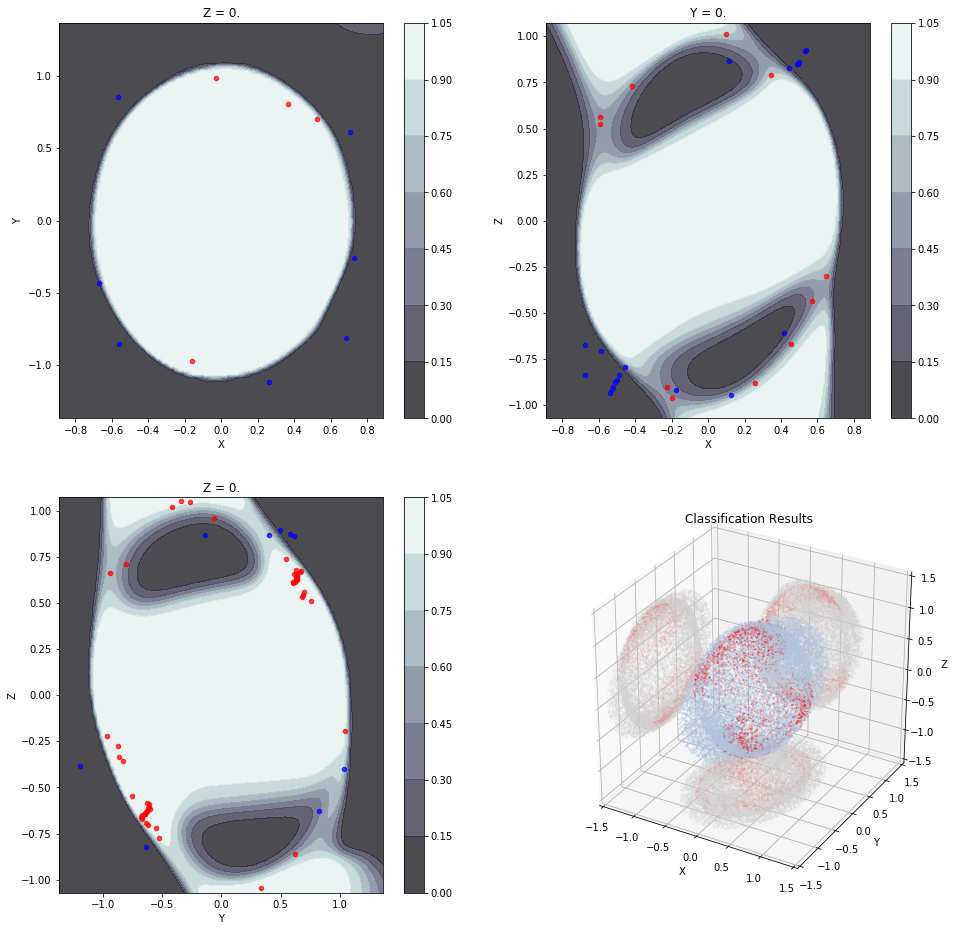

In [17]:
## First, reset the default graph...
tf.reset_default_graph()
#
## Construct Model
hLayersDict = {1:16, 2:16, 3:16, 4:16, 5:16, 6:16, 7:16}
model = DNNConstructor(3, hLayersDict, activation=tf.nn.tanh )
print( model.summary() )
#
##=========================================#
##             Training DNN                #
##=========================================#
## Compiling the model:
model.compile( optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy']  )
#
## We add a tensorboard callback:
tbCallBack = tf.keras.callbacks.TensorBoard( log_dir='./DNN_vs_SVM_I', 
                                             histogram_freq=1,
                                             batch_size=32, 
                                             write_graph=True, 
                                             write_images=True,
                                             write_grads=True,
                                             update_freq='epoch')
#
## Early stopping callback to prevent overfitting:
earlystopCallback = tf.keras.callbacks.EarlyStopping( monitor='val_loss',
                                                      min_delta=0.0001,
                                                      patience=10,
                                                      verbose=0,
                                                      mode='auto',
                                                      baseline=None,
                                                      restore_best_weights=True )
#
## Train model
model.fit( x=x_train,
           y=y_train,
           batch_size=32,
           epochs=10000,
           verbose=1,
           callbacks=[earlystopCallback,tbCallBack],
           validation_split=0.2,
           #validation_data=None,
           shuffle=True,
           #class_weight=None,
           sample_weight=None,
           initial_epoch=0,
           steps_per_epoch=None,
           #validation_steps=None,
           #validation_freq=1,
           #max_queue_size=10,
           workers=8,
           use_multiprocessing=True )
#
## Predict based on the Test Set:
y_test_predict = model.predict( x=x_test,
                                workers=8,
                                use_multiprocessing=True )
#
## Evaluate Metrics:
print( classification_report( y_test, 
                              np.argmax(y_test_predict,axis=1), 
                              target_names=class_names )  )

#=============================================================================
## Visualize the result:
#    The idea is to use the probability for the "1"
#    class for the contour plots: P(Class_B)=1
minVals = np.minimum( classA.min(axis=0), classB.min(axis=0) )
maxVals = np.maximum( classA.max(axis=0), classB.max(axis=0) )
x_array = np.linspace( minVals[0], maxVals[0], 100)
y_array = np.linspace( minVals[1], maxVals[1], 100)
z_array = np.linspace( minVals[2], maxVals[2], 100)
##
fig = plt.figure(figsize=(16,16))
#
ax = fig.add_subplot(221)
xx, yy = np.meshgrid( x_array, y_array )
cr = model.predict( x=np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx).ravel()],
                    workers=8,
                    use_multiprocessing=True )[:,1]
cr = cr.reshape(xx.shape)
cb = ax.contourf(xx, yy, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,2]>-0.001,classA[:,2]<0.001), 0],
            classA[ np.logical_and(classA[:,2]>-0.001,classA[:,2]<0.001), 1], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,2]>-0.001,classB[:,2]<0.001), 0],
            classB[ np.logical_and(classB[:,2]>-0.001,classB[:,2]<0.001), 1], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Z = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(222)
xx, zz = np.meshgrid( x_array, z_array )
cr = model.predict( x=np.c_[xx.ravel(), np.zeros_like(xx).ravel(), zz.ravel()],
                    workers=8,
                    use_multiprocessing=True )[:,1]
cr = cr.reshape(xx.shape)
cb = ax.contourf(xx, zz, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,1]>-0.001,classA[:,1]<0.001), 0],
            classA[ np.logical_and(classA[:,1]>-0.001,classA[:,1]<0.001), 2], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,1]>-0.001,classB[:,1]<0.001), 0],
            classB[ np.logical_and(classB[:,1]>-0.001,classB[:,1]<0.001), 2], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Y = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(223)
yy, zz = np.meshgrid( y_array, z_array )
cr = model.predict( x=np.c_[np.zeros_like(yy).ravel(),yy.ravel(), zz.ravel()],
                    workers=8,
                    use_multiprocessing=True )[:,1]
cr = cr.reshape(yy.shape)
cb = ax.contourf(yy, zz, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,0]>-0.001,classA[:,0]<0.001), 1],
            classA[ np.logical_and(classA[:,0]>-0.001,classA[:,0]<0.001), 2], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,0]>-0.001,classB[:,0]<0.001), 1],
            classB[ np.logical_and(classB[:,0]>-0.001,classB[:,0]<0.001), 2], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Z = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(224, projection='3d')
ax.set_title( "Classification Results" )
Y_pred = np.argmax( model.predict(x=X,workers=8,use_multiprocessing=True), axis=1 )
colors = np.where( Y==Y_pred, 'lightsteelblue', 'red' )
temp_features = np.concatenate((classA,classB),axis=0)
ax.scatter( temp_features[:,0], temp_features[:,1], temp_features[:,2], 
            s=1., c=colors, marker='o', alpha=.25 )
colors = np.where( Y==Y_pred, 'lightgray', 'lightcoral' )
ax.scatter( temp_features[:,0], temp_features[:,2], marker='o', c=colors, alpha=.15, s=1., zdir='y', zs=+1.5)  # XZ
ax.scatter( temp_features[:,1], temp_features[:,2], marker='o', c=colors, alpha=.15, s=1., zdir='x', zs=-1.5)  # YZ
ax.scatter( temp_features[:,0], temp_features[:,1], marker='o', c=colors, alpha=.15, s=1., zdir='z', zs=-1.5)  # XY
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-1.5,1.5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#
plt.show()

-----
## Case III: Classification on Random Data

This time, we create two completely random datasets and try to classify them:

Class A:  (10110, 3)
Class B:  (10100, 3)


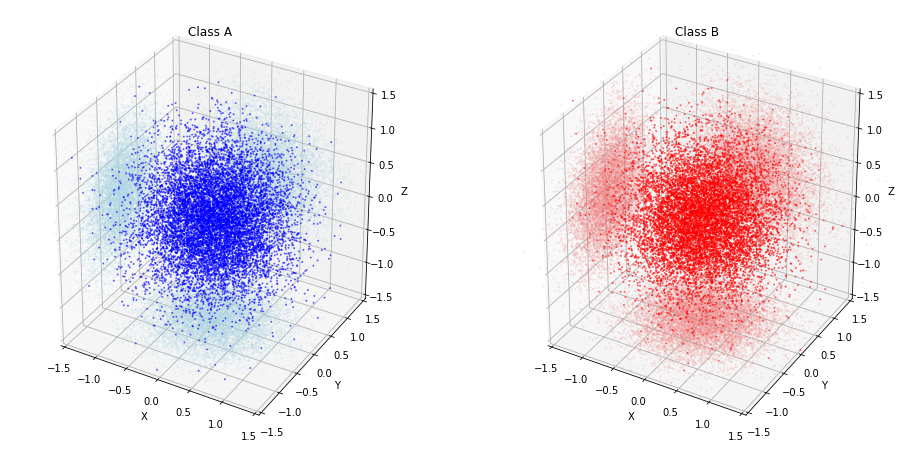

Full  Set Size:  20210
Train Set Size:  16168
Test  Set Size:  4042


In [4]:
## Define Two Classes: A & B:
n = 10110
classA = np.c_[ 0.5*np.random.randn(n),
                0.5*np.random.randn(n),
                0.5*np.random.randn(n) ]
print( "Class A: ", classA.shape )
#
n = 10100
classB = np.c_[ 0.5*np.random.randn(n),
                0.5*np.random.randn(n),
                0.5*np.random.randn(n) ]
print( "Class B: ", classB.shape )
#
## Visualize the results
fig = plt.figure(figsize=(16, 8))
#
ax = fig.add_subplot(121, projection='3d')
ax.set_title( "Class A" )
ax.scatter( classA[:,0], classA[:,1], classA[:,2], 
            s=1., c='b', marker='o', alpha=.5, label='Class A' )
ax.scatter( classA[:,0], classA[:,2], marker='o', c='lightblue', alpha=.15, s=1., zdir='y', zs=+1.5)  # XZ
ax.scatter( classA[:,1], classA[:,2], marker='o', c='lightblue', alpha=.15, s=1., zdir='x', zs=-1.5)  # YZ
ax.scatter( classA[:,0], classA[:,1], marker='o', c='lightblue', alpha=.15, s=1., zdir='z', zs=-1.5)  # XY
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-1.5,1.5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#
ax = fig.add_subplot(122, projection='3d')
ax.set_title( "Class B" )
ax.scatter( classB[:,0], classB[:,1], classB[:,2], 
            s=1., c='r', marker='o', alpha=.5, label='Class B' )
ax.scatter( classB[:,0], classB[:,2], marker='o', c='lightcoral', alpha=.15, s=1., zdir='y', zs=+1.5)  # XZ
ax.scatter( classB[:,1], classB[:,2], marker='o', c='lightcoral', alpha=.15, s=1., zdir='x', zs=-1.5)  # YZ
ax.scatter( classB[:,0], classB[:,1], marker='o', c='lightcoral', alpha=.15, s=1., zdir='z', zs=-1.5)  # XY
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-1.5,1.5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#
plt.show()
#
#================================================
## Split data into train and test sets: 
X = np.concatenate((classA,classB),axis=0)
Y = np.concatenate((np.zeros(max(classA.shape),dtype=np.uint8),
                    np.ones(max(classB.shape),dtype=np.uint8)),axis=0)
indcies_array = np.random.randint( low=0, high=(max(X.shape)-1), size=max(X.shape) )
x_train = X[ indcies_array[int(0.2*max(X.shape)):] ]
y_train = Y[ indcies_array[int(0.2*max(X.shape)):] ]
x_test = X[ indcies_array[0:int(0.2*max(X.shape))] ]
y_test = Y[ indcies_array[0:int(0.2*max(X.shape))] ]
print( "Full  Set Size: ", max(Y.shape) )
print( "Train Set Size: ", max(y_train.shape) )
print( "Test  Set Size: ", max(y_test.shape) )

              precision    recall  f1-score   support

     class A       0.51      0.37      0.43      2002
     class B       0.51      0.66      0.58      2040

    accuracy                           0.51      4042
   macro avg       0.51      0.51      0.50      4042
weighted avg       0.51      0.51      0.50      4042



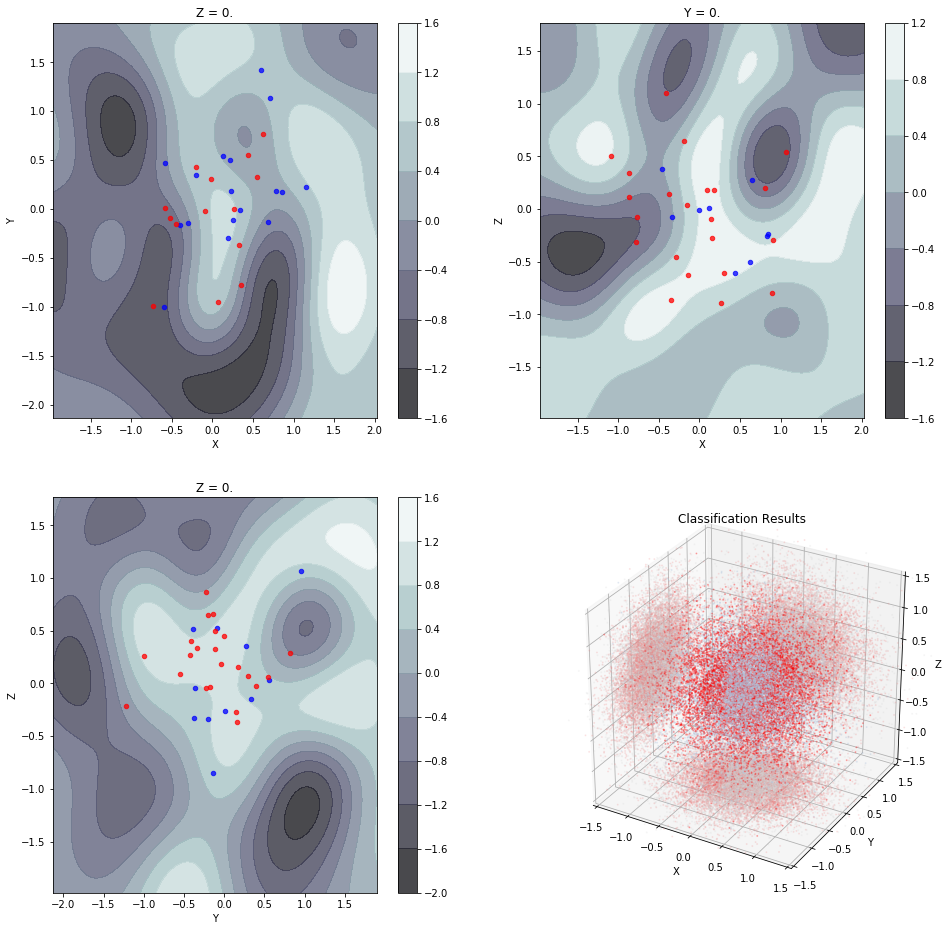

In [5]:
clf = svm.SVC( kernel='rbf',
               degree=2,
               gamma='scale',
               cache_size=2000.,
               class_weight='balanced' )
clf.fit( x_train, y_train )
class_names = ['class A', 'class B']
print( classification_report( y_test, 
                              clf.predict(x_test), 
                              target_names=class_names )  )
#
## Visualize the fit:
minVals = np.minimum( classA.min(axis=0), classB.min(axis=0) )
maxVals = np.maximum( classA.max(axis=0), classB.max(axis=0) )
x_array = np.linspace( minVals[0], maxVals[0], 100)
y_array = np.linspace( minVals[1], maxVals[1], 100)
z_array = np.linspace( minVals[2], maxVals[2], 100)
##
fig = plt.figure(figsize=(16,16))
#
ax = fig.add_subplot(221)
xx, yy = np.meshgrid( x_array, y_array )
cr = clf.decision_function( np.c_[xx.ravel(), 
                                  yy.ravel(), 
                                  np.zeros_like(xx).ravel()] )
cr = cr.reshape(xx.shape)
cb = ax.contourf(xx, yy, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,2]>-0.001,classA[:,2]<0.001), 0],
            classA[ np.logical_and(classA[:,2]>-0.001,classA[:,2]<0.001), 1], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,2]>-0.001,classB[:,2]<0.001), 0],
            classB[ np.logical_and(classB[:,2]>-0.001,classB[:,2]<0.001), 1], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Z = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(222)
xx, zz = np.meshgrid( x_array, z_array )
cr = clf.decision_function( np.c_[xx.ravel(), 
                                  np.zeros_like(xx).ravel(), 
                                  zz.ravel()] )
cr = cr.reshape(xx.shape)
cb = ax.contourf(xx, zz, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,1]>-0.001,classA[:,1]<0.001), 0],
            classA[ np.logical_and(classA[:,1]>-0.001,classA[:,1]<0.001), 2], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,1]>-0.001,classB[:,1]<0.001), 0],
            classB[ np.logical_and(classB[:,1]>-0.001,classB[:,1]<0.001), 2], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Y = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(223)
yy, zz = np.meshgrid( y_array, z_array )
cr = clf.decision_function( np.c_[np.zeros_like(yy).ravel(),
                                  yy.ravel(), 
                                  zz.ravel()] )
cr = cr.reshape(yy.shape)
cb = ax.contourf(yy, zz, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,0]>-0.001,classA[:,0]<0.001), 1],
            classA[ np.logical_and(classA[:,0]>-0.001,classA[:,0]<0.001), 2], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,0]>-0.001,classB[:,0]<0.001), 1],
            classB[ np.logical_and(classB[:,0]>-0.001,classB[:,0]<0.001), 2], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Z = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(224, projection='3d')
ax.set_title( "Classification Results" )
colors = np.where( Y==clf.predict(X), 'lightsteelblue', 'red' )
temp_features = np.concatenate((classA,classB),axis=0)
ax.scatter( temp_features[:,0], temp_features[:,1], temp_features[:,2], 
            s=1., c=colors, marker='o', alpha=.25 )
colors = np.where( Y==clf.predict(X), 'lightgray', 'lightcoral' )
ax.scatter( temp_features[:,0], temp_features[:,2], marker='o', c=colors, alpha=.15, s=1., zdir='y', zs=+1.5)  # XZ
ax.scatter( temp_features[:,1], temp_features[:,2], marker='o', c=colors, alpha=.15, s=1., zdir='x', zs=-1.5)  # YZ
ax.scatter( temp_features[:,0], temp_features[:,1], marker='o', c=colors, alpha=.15, s=1., zdir='z', zs=-1.5)  # XY
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-1.5,1.5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#
plt.show()

W0910 22:16:43.193277 140653160646464 deprecation.py:506] From /home/sedigh/PYTHON/ML/lib64/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 16)                64        
_________________________________________________________________
Dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
Dense_7 (Dense)              (None, 16)                2

12934/12934 [==============================] - 1s 69us/sample - loss: 0.6932 - acc: 0.4947 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 103/10000
12934/12934 [==============================] - 1s 71us/sample - loss: 0.6932 - acc: 0.4967 - val_loss: 0.6932 - val_acc: 0.4985
Epoch 104/10000
12934/12934 [==============================] - 1s 69us/sample - loss: 0.6932 - acc: 0.4963 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 105/10000
12934/12934 [==============================] - 1s 68us/sample - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6931 - val_acc: 0.5009
Epoch 106/10000
12934/12934 [==============================] - 1s 69us/sample - loss: 0.6932 - acc: 0.4975 - val_loss: 0.6931 - val_acc: 0.4991
Epoch 107/10000
12934/12934 [==============================] - 1s 70us/sample - loss: 0.6932 - acc: 0.4994 - val_loss: 0.6933 - val_acc: 0.5006
Epoch 108/10000
12934/12934 [==============================] - 1s 68us/sample - loss: 0.6931 - acc: 0.5019 - val_loss: 0.6932 - val_acc: 0.4997
Epoch 10

Epoch 159/10000
12934/12934 [==============================] - 2s 128us/sample - loss: 0.6932 - acc: 0.4973 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 160/10000
12934/12934 [==============================] - 1s 110us/sample - loss: 0.6931 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 161/10000
12934/12934 [==============================] - 1s 107us/sample - loss: 0.6931 - acc: 0.4990 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 162/10000
12934/12934 [==============================] - 1s 114us/sample - loss: 0.6933 - acc: 0.4933 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 163/10000
12934/12934 [==============================] - 2s 129us/sample - loss: 0.6931 - acc: 0.5036 - val_loss: 0.6945 - val_acc: 0.5028
Epoch 164/10000
12934/12934 [==============================] - 1s 112us/sample - loss: 0.6933 - acc: 0.5048 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 165/10000
12934/12934 [==============================] - 2s 131us/sample - loss: 0.6932 - acc: 0.4963 - val_loss: 0.6932 - v

Epoch 272/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4942 - val_loss: 0.6931 - val_acc: 0.5049
Epoch 273/10000
12934/12934 [==============================] - 1s 61us/sample - loss: 0.6932 - acc: 0.4968 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 274/10000
12934/12934 [==============================] - 1s 58us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 275/10000
12934/12934 [==============================] - 1s 58us/sample - loss: 0.6933 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 276/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6931 - val_acc: 0.5056
Epoch 277/10000
12934/12934 [==============================] - 1s 77us/sample - loss: 0.6933 - acc: 0.4949 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 278/10000
12934/12934 [==============================] - 1s 70us/sample - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6931 - val_acc:

Epoch 329/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5034 - val_loss: 0.6931 - val_acc: 0.5028
Epoch 330/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5060 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 331/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4961 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 332/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4968 - val_loss: 0.6930 - val_acc: 0.5006
Epoch 333/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6933 - acc: 0.4983 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 334/10000
12934/12934 [==============================] - 1s 58us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 335/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6931 - val_acc:

Epoch 386/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 387/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4964 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 388/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 389/10000
12934/12934 [==============================] - 1s 58us/sample - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 390/10000
12934/12934 [==============================] - 1s 58us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5003
Epoch 391/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 392/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6931 - val_acc:

Epoch 443/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4974 - val_loss: 0.6931 - val_acc: 0.5003
Epoch 444/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4939 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 445/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6931 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 446/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 447/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4954 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 448/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4954 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 449/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5017 - val_loss: 0.6932 - val_acc:

Epoch 500/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4978 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 501/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 502/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4936 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 503/10000
12934/12934 [==============================] - 1s 58us/sample - loss: 0.6932 - acc: 0.4974 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 504/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4973 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 505/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4948 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 506/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4982 - val_loss: 0.6932 - val_acc:

Epoch 557/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6930 - val_acc: 0.5006
Epoch 558/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6930 - val_acc: 0.5065
Epoch 559/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4968 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 560/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6931 - acc: 0.4954 - val_loss: 0.6930 - val_acc: 0.5043
Epoch 561/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6930 - val_acc: 0.5062
Epoch 562/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5037 - val_loss: 0.6930 - val_acc: 0.5006
Epoch 563/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5048 - val_loss: 0.6929 - val_acc:

Epoch 614/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4951 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 615/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 616/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4948 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 617/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5036 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 618/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5052 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 619/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 620/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6932 - val_acc:

Epoch 671/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 672/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6933 - acc: 0.4956 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 673/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4957 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 674/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 675/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4937 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 676/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 677/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6931 - val_acc:

Epoch 728/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 729/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6931 - acc: 0.5046 - val_loss: 0.6934 - val_acc: 0.5006
Epoch 730/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6933 - acc: 0.4991 - val_loss: 0.6933 - val_acc: 0.5006
Epoch 731/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 732/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5022 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 733/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4974 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 734/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6931 - val_acc:

Epoch 785/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 786/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6934 - val_acc: 0.5006
Epoch 787/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6931 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 788/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4962 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 789/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 790/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 791/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4917 - val_loss: 0.6932 - val_acc:

Epoch 842/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 843/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 844/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6933 - acc: 0.4961 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 845/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4962 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 846/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 847/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4979 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 848/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6932 - val_acc:

Epoch 899/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5032 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 900/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4922 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 901/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4954 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 902/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4974 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 903/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6933 - val_acc: 0.5006
Epoch 904/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 905/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6931 - val_acc:

Epoch 956/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4979 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 957/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4940 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 958/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 959/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4948 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 960/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 961/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 962/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5035 - val_loss: 0.6933 - val_acc:

Epoch 1013/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5021 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1014/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5021 - val_loss: 0.6933 - val_acc: 0.5006
Epoch 1015/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1016/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1017/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4939 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1018/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1019/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - v

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1126/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4974 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 1127/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1128/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1129/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5032 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 1130/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5050 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1131/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.4994
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5021 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 1238/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 1239/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1240/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1241/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4947 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1242/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 1243/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 1350/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1351/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1352/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 1353/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6933 - acc: 0.4981 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1354/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1355/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4968 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4976 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 1462/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6933 - acc: 0.4965 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 1463/10000
12934/12934 [==============================] - 1s 52us/sample - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 1464/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 1465/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4965 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 1466/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 1467/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4979 - val_loss: 0.6931 - val_acc: 0.4994
Ep

12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1574/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1575/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1576/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 1577/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4936 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1578/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1579/10000
12934/12934 [==============================] - 1s 58us/sample - loss: 0.6932 - acc: 0.5021 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 1686/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1687/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1688/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1689/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4947 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1690/10000
12934/12934 [==============================] - 1s 59us/sample - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1691/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 55us/sample - loss: 0.6931 - acc: 0.5050 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 1798/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6933 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1799/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1800/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1801/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1802/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1803/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 1910/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 1911/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5029 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 1912/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4944 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 1913/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1914/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 1915/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.4994
Ep

12934/12934 [==============================] - 1s 59us/sample - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2022/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2023/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2024/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 2025/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2026/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 2027/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5024 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2134/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5035 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2135/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4959 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2136/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4970 - val_loss: 0.6933 - val_acc: 0.5006
Epoch 2137/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 2138/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2139/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4979 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2246/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5033 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 2247/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 2248/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5024 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2249/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 2250/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2251/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2358/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2359/10000
12934/12934 [==============================] - 1s 52us/sample - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 2360/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6931 - acc: 0.5056 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2361/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2362/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2363/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4976 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2470/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5044 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 2471/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4978 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2472/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4968 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2473/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4957 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2474/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5021 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2475/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 2582/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4954 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2583/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2584/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2585/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4925 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2586/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2587/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4978 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6933 - acc: 0.4900 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2694/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 2695/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2696/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2697/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4964 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 2698/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4965 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2699/10000
12934/12934 [==============================] - 1s 61us/sample - loss: 0.6932 - acc: 0.4940 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4964 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2806/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2807/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4971 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 2808/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4962 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2809/10000
12934/12934 [==============================] - 1s 52us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2810/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2811/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 2918/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4934 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2919/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 2920/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4951 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 2921/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2922/10000
12934/12934 [==============================] - 1s 52us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 2923/10000
12934/12934 [==============================] - 1s 52us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.4994
Ep

12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4978 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3030/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 3031/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5027 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 3032/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 3033/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3034/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4971 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3035/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4973 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3142/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 3143/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3144/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 3145/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 3146/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3147/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4964 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3254/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4956 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3255/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4973 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3256/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3257/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 3258/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 3259/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3366/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3367/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 3368/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3369/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5036 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 3370/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4967 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3371/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 50us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 3478/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5055 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3479/10000
12934/12934 [==============================] - 1s 59us/sample - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3480/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3481/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3482/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3483/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3590/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6933 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3591/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3592/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6931 - acc: 0.5070 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 3593/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5033 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3594/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3595/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3702/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 3703/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3704/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 3705/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3706/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 3707/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4962 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 51us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3814/10000
12934/12934 [==============================] - 1s 58us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3815/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5036 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 3816/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4979 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 3817/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5039 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 3818/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4940 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3819/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.4994
Ep

12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3926/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3927/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4967 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 3928/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 3929/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6931 - acc: 0.5053 - val_loss: 0.6933 - val_acc: 0.5006
Epoch 3930/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5029 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 3931/10000
12934/12934 [==============================] - 1s 59us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 4038/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4039/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4953 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 4040/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4041/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4957 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 4042/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 4043/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4150/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 4151/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4942 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4152/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 4153/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4154/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 4155/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5032 - val_loss: 0.6933 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4974 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4262/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6931 - acc: 0.5049 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 4263/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 4264/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6931 - acc: 0.5039 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 4265/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4979 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 4266/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4267/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 4374/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4375/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4945 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 4376/10000
12934/12934 [==============================] - 1s 49us/sample - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4377/10000
12934/12934 [==============================] - 1s 52us/sample - loss: 0.6932 - acc: 0.5046 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 4378/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4937 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4379/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4978 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 4486/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4487/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 4488/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4489/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4950 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4490/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4491/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6931 - val_acc: 0.4994
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4598/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 4599/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5029 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 4600/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4940 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 4601/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4974 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4602/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5035 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4603/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4957 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4710/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5022 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 4711/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4712/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4979 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4713/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4714/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4715/10000
12934/12934 [==============================] - 1s 52us/sample - loss: 0.6932 - acc: 0.4967 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4939 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4822/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4823/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 4824/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4982 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4825/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4982 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4826/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6931 - acc: 0.5050 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 4827/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4957 - val_loss: 0.6932 - val_acc: 0.4994
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 4934/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 4935/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4936/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4937/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 4938/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 4939/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5029 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 5046/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5047/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5048/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5022 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5049/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5050/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6933 - acc: 0.5009 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5051/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4941 - val_loss: 0.6931 - val_acc: 0.5025
Epoch 5158/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5022 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 5159/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5160/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5161/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5024 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5162/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5163/10000
12934/12934 [==============================] - 1s 51us/sample - loss: 0.6932 - acc: 0.4961 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5270/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4973 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5271/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5272/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5273/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5274/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4964 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5275/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5382/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4967 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 5383/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4927 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5384/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 5385/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4951 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5386/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5387/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5494/10000
12934/12934 [==============================] - 1s 63us/sample - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5495/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4939 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5496/10000
12934/12934 [==============================] - 1s 50us/sample - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5497/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 5498/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4956 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5499/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6931 - val_acc: 0.4994
Ep

12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5606/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4979 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5607/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5608/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5609/10000
12934/12934 [==============================] - 1s 58us/sample - loss: 0.6932 - acc: 0.4945 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5610/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5611/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5027 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4974 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5718/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5719/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 5720/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6933 - val_acc: 0.5006
Epoch 5721/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5722/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5029 - val_loss: 0.6931 - val_acc: 0.5046
Epoch 5723/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6933 - acc: 0.5004 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5830/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5831/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5832/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4968 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5833/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 5834/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4957 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5835/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4974 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5942/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4968 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5943/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5035 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5944/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5945/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 5946/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5947/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5029 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 6054/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6055/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5018 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6056/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4973 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6057/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 6058/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6059/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6166/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6167/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6168/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 6169/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4971 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6170/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6171/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4930 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4978 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6278/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 6279/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4951 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6280/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6281/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 6282/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6283/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4944 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6390/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6391/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6392/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 6393/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6394/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6395/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4970 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6502/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 6503/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 6504/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4951 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 6505/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4953 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6506/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6507/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4971 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6614/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4956 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6615/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 6616/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4965 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 6617/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5029 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6618/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6933 - val_acc: 0.5006
Epoch 6619/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 6726/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 6727/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4945 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6728/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6933 - val_acc: 0.5006
Epoch 6729/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 6730/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6731/10000
12934/12934 [==============================] - 1s 58us/sample - loss: 0.6932 - acc: 0.4959 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 6838/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6839/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6840/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5021 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 6841/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 6842/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6843/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6950/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6951/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4957 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6952/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6953/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6954/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4970 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 6955/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6933 - acc: 0.4968 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 7062/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7063/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4973 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 7064/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7065/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7066/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 7067/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4948 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7174/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4982 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 7175/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4976 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7176/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 7177/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 7178/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 7179/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4957 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7286/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7287/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7288/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 7289/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 7290/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 7291/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4954 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7398/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5027 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 7399/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5018 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7400/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7401/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 7402/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4944 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7403/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4937 - val_loss: 0.6935 - val_acc: 0.5006
Epoch 7510/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6933 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7511/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 7512/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5032 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 7513/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4973 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7514/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7515/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 7622/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4978 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7623/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7624/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7625/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7626/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 7627/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6931 - val_acc: 0.4994
Ep

12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 7734/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7735/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4925 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7736/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4979 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7737/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7738/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4968 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7739/10000
12934/12934 [==============================] - 1s 58us/sample - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6931 - val_acc: 0.4994
Ep

12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 7846/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7847/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 7848/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4948 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 7849/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7850/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7851/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4950 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4974 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7958/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 7959/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4971 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 7960/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 7961/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6933 - acc: 0.4959 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 7962/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4959 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 7963/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4967 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8070/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5029 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 8071/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4964 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8072/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 8073/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4953 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8074/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8075/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4922 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8182/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4968 - val_loss: 0.6934 - val_acc: 0.5006
Epoch 8183/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8184/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8185/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8186/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4973 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8187/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8294/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8295/10000
12934/12934 [==============================] - 1s 63us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8296/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8297/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5021 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 8298/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4964 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8299/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4970 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8406/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8407/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6933 - acc: 0.4947 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8408/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8409/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6933 - val_acc: 0.5006
Epoch 8410/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8411/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4970 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4979 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8518/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4964 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8519/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8520/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8521/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8522/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8523/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 58us/sample - loss: 0.6932 - acc: 0.4962 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8630/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8631/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8632/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4947 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8633/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8634/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8635/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5053 - val_loss: 0.6932 - val_acc: 0.4994
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5070 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 8742/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6933 - acc: 0.4948 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8743/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4877 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8744/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4925 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8745/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8746/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8747/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4964 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8854/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4979 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8855/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8856/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8857/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.4974 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8858/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8859/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4968 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4971 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8966/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8967/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8968/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 8969/10000
12934/12934 [==============================] - 1s 60us/sample - loss: 0.6932 - acc: 0.5043 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 8970/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6933 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 8971/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5022 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 9078/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9079/10000
12934/12934 [==============================] - 1s 52us/sample - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9080/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9081/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9082/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9083/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4959 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9190/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6933 - acc: 0.4987 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9191/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 9192/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4954 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9193/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 9194/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4964 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9195/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6931 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 9302/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9303/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6933 - acc: 0.4961 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9304/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4971 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9305/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9306/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9307/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5032 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9414/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6933 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 9415/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 9416/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9417/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9418/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9419/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4942 - val_loss: 0.6933 - val_acc: 0.5006
Epoch 9526/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9527/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 9528/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5033 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9529/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9530/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5027 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 9531/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6933 - acc: 0.4987 - val_loss: 0.6932 - val_acc: 0.4994
Ep

12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9638/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 9639/10000
12934/12934 [==============================] - 1s 52us/sample - loss: 0.6932 - acc: 0.4945 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9640/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4982 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9641/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9642/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4937 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9643/10000
12934/12934 [==============================] - 1s 56us/sample - loss: 0.6932 - acc: 0.5018 - val_loss: 0.6932 - val_acc: 0.4994
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 9750/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9751/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9752/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.5021 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9753/10000
12934/12934 [==============================] - 1s 52us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9754/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6933 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9755/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4961 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9862/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6933 - acc: 0.4971 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9863/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9864/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9865/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9866/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9867/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.5021 - val_loss: 0.6932 - val_acc: 0.5006
Ep

12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4982 - val_loss: 0.6932 - val_acc: 0.4994
Epoch 9974/10000
12934/12934 [==============================] - 1s 57us/sample - loss: 0.6932 - acc: 0.4883 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9975/10000
12934/12934 [==============================] - 1s 55us/sample - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9976/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9977/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4982 - val_loss: 0.6931 - val_acc: 0.5006
Epoch 9978/10000
12934/12934 [==============================] - 1s 53us/sample - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 9979/10000
12934/12934 [==============================] - 1s 54us/sample - loss: 0.6932 - acc: 0.4968 - val_loss: 0.6932 - val_acc: 0.5006
Ep

/home/sedigh/PYTHON/ML/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


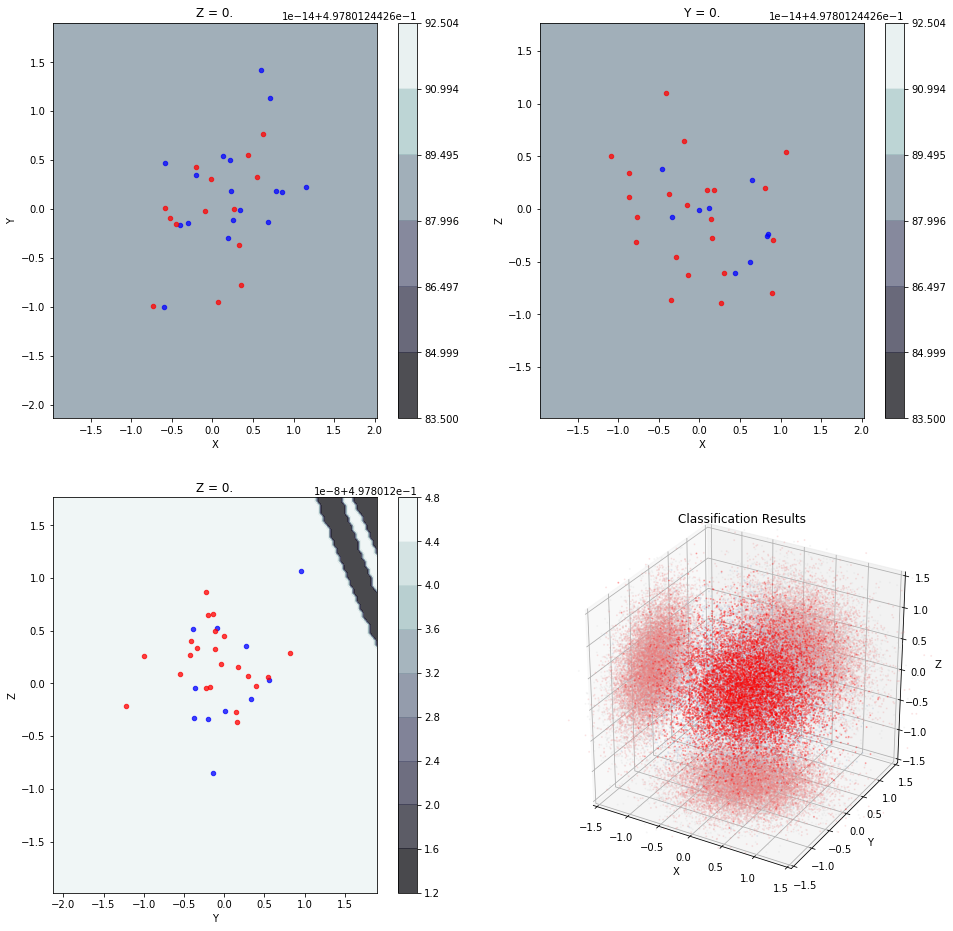

In [6]:
## First, reset the default graph...
tf.reset_default_graph()
#
## Construct Model
hLayersDict = {1:16, 2:16, 3:16, 4:16, 5:16, 6:16, 7:16, 8:16, 9:16, 10:16}
model = DNNConstructor(3, hLayersDict, activation=tf.nn.tanh )
print( model.summary() )
#
##=========================================#
##             Training DNN                #
##=========================================#
## Compiling the model:
model.compile( optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy']  )
#
## We add a tensorboard callback:
tbCallBack = tf.keras.callbacks.TensorBoard( log_dir='./Case_III', 
                                             histogram_freq=1,
                                             batch_size=32, 
                                             write_graph=True, 
                                             write_images=True,
                                             write_grads=True,
                                             update_freq='epoch')
#
## Early stopping callback to prevent overfitting:
earlystopCallback = tf.keras.callbacks.EarlyStopping( monitor='val_loss',
                                                      min_delta=0.0001,
                                                      patience=1000,
                                                      verbose=0,
                                                      mode='auto',
                                                      baseline=None,
                                                      restore_best_weights=True )
#
## Train model
model.fit( x=x_train,
           y=y_train,
           batch_size=32,
           epochs=10000,
           verbose=1,
           callbacks=[tbCallBack],#[earlystopCallback,tbCallBack],
           validation_split=0.2,
           #validation_data=None,
           shuffle=True,
           #class_weight=None,
           sample_weight=None,
           initial_epoch=0,
           steps_per_epoch=None,
           #validation_steps=None,
           #validation_freq=1,
           #max_queue_size=10,
           workers=8,
           use_multiprocessing=True )
#
## Predict based on the Test Set:
y_test_predict = model.predict( x=x_test,
                                workers=8,
                                use_multiprocessing=True )
#
## Evaluate Metrics:
print( classification_report( y_test, 
                              np.argmax(y_test_predict,axis=1), 
                              target_names=class_names )  )

#=============================================================================
## Visualize the result:
#    The idea is to use the probability for the "1"
#    class for the contour plots: P(Class_B)=1
minVals = np.minimum( classA.min(axis=0), classB.min(axis=0) )
maxVals = np.maximum( classA.max(axis=0), classB.max(axis=0) )
x_array = np.linspace( minVals[0], maxVals[0], 100)
y_array = np.linspace( minVals[1], maxVals[1], 100)
z_array = np.linspace( minVals[2], maxVals[2], 100)
##
fig = plt.figure(figsize=(16,16))
#
ax = fig.add_subplot(221)
xx, yy = np.meshgrid( x_array, y_array )
cr = model.predict( x=np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx).ravel()],
                    workers=8,
                    use_multiprocessing=True )[:,1]
cr = cr.reshape(xx.shape)
cb = ax.contourf(xx, yy, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,2]>-0.001,classA[:,2]<0.001), 0],
            classA[ np.logical_and(classA[:,2]>-0.001,classA[:,2]<0.001), 1], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,2]>-0.001,classB[:,2]<0.001), 0],
            classB[ np.logical_and(classB[:,2]>-0.001,classB[:,2]<0.001), 1], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Z = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(222)
xx, zz = np.meshgrid( x_array, z_array )
cr = model.predict( x=np.c_[xx.ravel(), np.zeros_like(xx).ravel(), zz.ravel()],
                    workers=8,
                    use_multiprocessing=True )[:,1]
cr = cr.reshape(xx.shape)
cb = ax.contourf(xx, zz, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,1]>-0.001,classA[:,1]<0.001), 0],
            classA[ np.logical_and(classA[:,1]>-0.001,classA[:,1]<0.001), 2], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,1]>-0.001,classB[:,1]<0.001), 0],
            classB[ np.logical_and(classB[:,1]>-0.001,classB[:,1]<0.001), 2], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Y = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(223)
yy, zz = np.meshgrid( y_array, z_array )
cr = model.predict( x=np.c_[np.zeros_like(yy).ravel(),yy.ravel(), zz.ravel()],
                    workers=8,
                    use_multiprocessing=True )[:,1]
cr = cr.reshape(yy.shape)
cb = ax.contourf(yy, zz, cr, alpha=0.75, cmap=plt.cm.bone)
ax.scatter( classA[ np.logical_and(classA[:,0]>-0.001,classA[:,0]<0.001), 1],
            classA[ np.logical_and(classA[:,0]>-0.001,classA[:,0]<0.001), 2], 
            c='blue', s=20., alpha=0.75, cmap=plt.cm.bone )
ax.scatter( classB[ np.logical_and(classB[:,0]>-0.001,classB[:,0]<0.001), 1],
            classB[ np.logical_and(classB[:,0]>-0.001,classB[:,0]<0.001), 2], 
            c='red',  s=20., alpha=0.75, cmap=plt.cm.bone )
ax.set_aspect('auto')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Z = 0.')
fig.colorbar(cb)
#
ax = fig.add_subplot(224, projection='3d')
ax.set_title( "Classification Results" )
Y_pred = np.argmax( model.predict(x=X,workers=8,use_multiprocessing=True), axis=1 )
colors = np.where( Y==Y_pred, 'lightsteelblue', 'red' )
temp_features = np.concatenate((classA,classB),axis=0)
ax.scatter( temp_features[:,0], temp_features[:,1], temp_features[:,2], 
            s=1., c=colors, marker='o', alpha=.25 )
colors = np.where( Y==Y_pred, 'lightgray', 'lightcoral' )
ax.scatter( temp_features[:,0], temp_features[:,2], marker='o', c=colors, alpha=.15, s=1., zdir='y', zs=+1.5)  # XZ
ax.scatter( temp_features[:,1], temp_features[:,2], marker='o', c=colors, alpha=.15, s=1., zdir='x', zs=-1.5)  # YZ
ax.scatter( temp_features[:,0], temp_features[:,1], marker='o', c=colors, alpha=.15, s=1., zdir='z', zs=-1.5)  # XY
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-1.5,1.5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#
plt.show()